# **project-taxi-analysis**

# Build a machine learning model

## PACE: Plan

Predict people who are particularly generous—those who will tip 20% or more

### **Task 1. Imports and data loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Run this cell to connect to gDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [55]:
df0 = pd.read_csv('gdrive/MyDrive/data/2017_Yellow_Taxi_Trip_Data.csv')
nyc_preds_means = pd.read_csv('gdrive/MyDrive/data/nyc_preds_means.csv')

In [56]:
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [57]:
nyc_preds_means.head(5)

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


#### Join the two dataframes

In [58]:
print(df0.shape)
print(nyc_preds_means.shape)
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)
print(df0.shape)

(22699, 18)
(22699, 3)
(22699, 21)


## PACE: **Analyze**

### **Task 2. Feature engineering**

In [59]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

Customers who pay cash generally have a tip amount of $0. To meet the modeling objective, use only the customers who pay with credit card.

In [60]:
#df1=df0.copy()
#df1=df1[df1['payment_type']==1]
df1 = df0[df0['payment_type']==1]

##### **Target**

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal.


In [61]:
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)
df1.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200


Create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [62]:
# Create 'generous' col (target)
df1['generous']=df1['tip_percent'].copy()
df1['generous']=df1['generous']>=0.2
df1['generous']=df1['generous'].replace({True:1,False:0})
print(df1['generous'])

0        1
1        1
2        0
3        1
5        1
        ..
22692    1
22693    1
22695    1
22697    0
22698    0
Name: generous, Length: 15265, dtype: int64


#### Create day column

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [63]:
df1['tpep_pickup_datetime']=pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime']=pd.to_datetime(df1['tpep_dropoff_datetime'])

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [64]:
# Create a 'day' col
import datetime as dt
df1['day']= df1['tpep_pickup_datetime'].dt.day_name().str.lower()
print(df1['day'])

0        saturday
1         tuesday
2          friday
3          sunday
5        saturday
           ...   
22692      sunday
22693    thursday
22695      sunday
22697    saturday
22698    thursday
Name: day, Length: 15265, dtype: object


#### Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [65]:
df1['am_rush']=df1['tpep_pickup_datetime'].copy()
df1['daytime']=df1['tpep_pickup_datetime'].copy()
df1['pm_rush']=df1['tpep_pickup_datetime'].copy()
df1['nighttime']=df1['tpep_pickup_datetime'].copy()

In [66]:
# Define 'am_rush()' conversion function (06:00–10:00)

def am_rush(df03):
    result = df03.copy()
    i = 0
    for temp in df03:

        if (temp.hour >= 6) and (temp.hour < 10):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [67]:
df1['am_rush']=am_rush(df1['am_rush'])
print(df1['am_rush'])

0        1
1        0
2        1
3        0
5        0
        ..
22692    0
22693    0
22695    0
22697    0
22698    0
Name: am_rush, Length: 15265, dtype: object


In [68]:
# Define 'daytime()' conversion function (10:00–16:00)

def daytime(df03):
    result = df03.copy()
    i = 0
    for temp in df03:

        if (temp.hour >= 10) and (temp.hour < 16):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [69]:
df1['daytime']=daytime(df1['daytime'])

In [70]:
# Define 'pm_rush()' conversion function (16:00–20:00)

def pm_rush(df03):
    result = df03.copy()
    i = 0
    for temp in df03:

        if (temp.hour >= 16) and (temp.hour < 20):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [71]:
df1['pm_rush']=pm_rush(df1['pm_rush'])

In [72]:
# Define 'nighttime()' conversion function (20:00–06:00)

def nighttime(df03):
    result = df03.copy()
    i = 0
    for temp in df03:

        if (temp.hour >= 20) or (temp.hour < 6):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [73]:
df1['nighttime']=nighttime(df1['nighttime'])

#### Create `month` column

Create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [74]:
df1['month']=df1['tpep_pickup_datetime'].dt.strftime('%b')

In [75]:
print(df1['month'].head(5))

0    Mar
1    Apr
2    Dec
3    May
5    Mar
Name: month, dtype: object


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed.

In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  mta_ta

In [77]:
# Drop columns
df04=df1.drop(['Unnamed: 0','tpep_pickup_datetime','tpep_dropoff_datetime','payment_type','trip_distance','tip_amount','tip_percent','total_amount','tolls_amount','fare_amount','extra','mta_tax','store_and_fwd_flag','improvement_surcharge'],axis=1)

#### Variable encoding

In [78]:
# 1. Define list of cols to convert to string
cols_to_str = {'RatecodeID', 'PULocationID', 'DOLocationID'}

# 2. Convert each column to string
for col in cols_to_str:
    df04[col]=df04[col].astype('str')

In [79]:
print(df04.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  object 
 3   PULocationID     15265 non-null  object 
 4   DOLocationID     15265 non-null  object 
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  object 
 11  daytime          15265 non-null  object 
 12  pm_rush          15265 non-null  object 
 13  nighttime        15265 non-null  object 
 14  month            15265 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 1.9+ MB
None


In [80]:
# Convert categoricals to binary
df3 = pd.get_dummies(df04, drop_first=True)

##### Evaluation metric

In [81]:
# Get class balance of 'generous' col
df3['generous'].value_counts()

generous
1    8035
0    7230
Name: count, dtype: int64

## PACE: **Construct**

### **Task 3. Modeling**

##### **Split the data**

In [82]:
# Isolate target variable (y)
y=df3['generous']

# Isolate the features (X)
X=df3.drop(['generous'], axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, stratify=y,
                                                    random_state=42)

##### **Random forest**

In [83]:
import pickle

def write_pickle(path, model_object, save_name:str):
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [84]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [2,3,4],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [10, 100, 300]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [85]:
# Enable when downloading already calculated model
#rf_cv = read_pickle('gdrive/MyDrive/REG/',"rf_cv")

In [86]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 5min 51s, sys: 1.32 s, total: 5min 53s
Wall time: 6min 1s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 300]},
             refit='f1', scoring={'f1', 'recall', 'precision', 'accuracy'})

In [87]:
# Enable when saving the model
write_pickle('gdrive/MyDrive/REG/', rf_cv, 'rf_cv')

Examine the best average score across all the validation folds.

In [88]:
# Examine best score
rf_cv.best_score_

0.6974934109303657

Examine the best combination of hyperparameters.

In [89]:
rf_cv.best_params_

{'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 10}

In [90]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [91]:
results = make_results('Random Forest CV', rf_cv,'f1')
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.574133,0.919571,0.697493,0.578447


Use your model to predict on the test data. Assign the results to a variable called `rf_preds`.

In [92]:
# Get scores on test data
rf_preds = rf_cv.predict(X_test)

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [93]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

###### RF test results

In [94]:
 # Get scores on test data
rf_test_result = get_test_scores('Random Forest test', rf_preds, y_test)

results = pd.concat([results, rf_test_result], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.574133,0.919571,0.697493,0.578447
0,Random Forest test,0.537324,0.971998,0.692069,0.544710


##### **XGBoost**

In [95]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4],
             'min_child_weight': [1,3],
             'learning_rate': [0.1],
             'n_estimators': [75]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [96]:
# Enable when downloading already calculated model
#xgb_cv = read_pickle('gdrive/MyDrive/REG/', "xgb_cv")

In [97]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 11.9 s, sys: 97.7 ms, total: 12 s
Wall time: 7.39 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [4],
                         'min_child_weight': [1, 3], 'n_estimators': [75]},
             refit='f1', scoring={'f1', 'recall', 'precision', 'accuracy'})

In [98]:
# Enable when saving the model
write_pickle('gdrive/MyDrive/REG/', xgb_cv, 'xgb_cv')

Get the best score from this model.

In [99]:
# Examine best score
xgb_cv.best_score_

0.7456353357313878

And the best parameters.

In [100]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 75}

##### XGB CV Results

In [101]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB CV', xgb_cv, 'f1')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.574133,0.919571,0.697493,0.578447
0,Random Forest test,0.537324,0.971998,0.692069,0.544710
0,XGB CV,0.694012,0.805694,0.745635,0.710694


In [102]:
# Get scores on test data
xgb_preds = xgb_cv.predict(X_test)

###### XGB test results

In [103]:
# Get scores on test data
xgb_preds = xgb_cv.best_estimator_.predict(X_test)
xgb_test_result = get_test_scores('XGBoost test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_result], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.574133,0.919571,0.697493,0.578447
0,Random Forest test,0.537324,0.971998,0.692069,0.544710
0,XGB CV,0.694012,0.805694,0.745635,0.710694
0,XGBoost test,0.685010,0.813317,0.743670,0.704880


Plot a confusion matrix of the model's predictions on the test data.

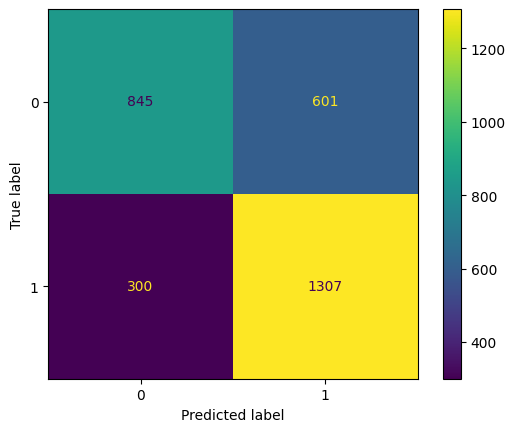

In [104]:
# Generate array of values for confusion matrix
model = xgb_cv
preds = xgb_preds
cm = confusion_matrix(y_test, preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot confusion matrix
disp.plot()
plt.show()

##### Feature importance

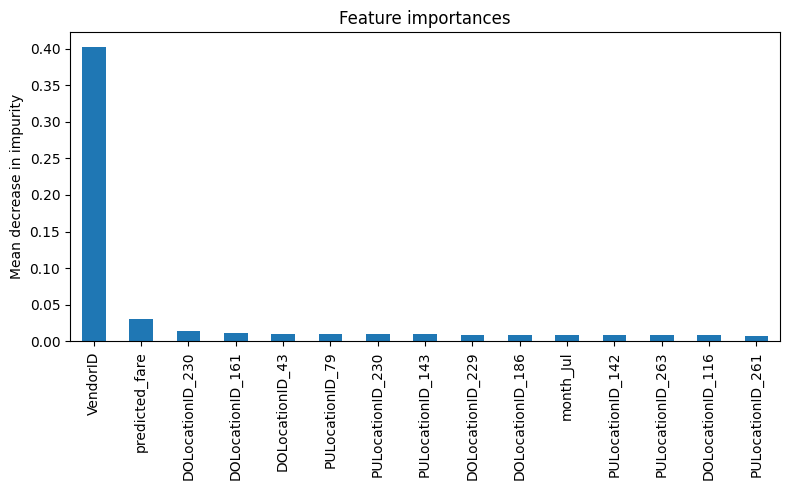

In [105]:
model=xgb_cv

importances = model.best_estimator_.feature_importances_
model_importances = pd.Series(importances, index=X_test.columns)
model_importances = model_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
model_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

## PACE: **Execute**

### **Task 4. Conclusion**

1. Recommend to use this XGB model. F1 score is 0.75 and Accuracy is 0.71. The test sets were predicted w/ 81% which is better than random guess by 31%.

2. Random Forest is not a transparent model. Vendor ID definitely has an influence for the better prediction result.

3. Pick up and Drop off locations seem to have an impact on the tipping amount. Maybe we can bring a new category for premium, medium, and low-end for pick-up and drop-off locations.
